Q-learning in Windy Gridworld

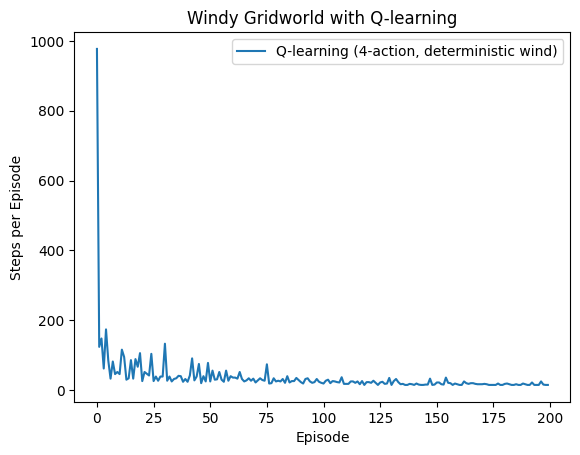

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

class WindyGridworld:
    """
    Windy Gridworld environment as in Sutton & Barto Example 6.5.
    State is (row, col).
    Actions are integer indices into [up, down, left, right] (and possibly diagonals).
    
    For Exercise 6.9, we can stick to the standard 4 actions or also try 8 actions. 
    Below is the standard 4-action version.
    """

    def __init__(self, rows=7, cols=10, 
                 start=(3, 0), goal=(3, 7),
                 wind_strength=None, 
                 stochastic_wind=False,
                 king_moves=False):
        """
        rows, cols: dimensions of the grid
        start: (row, col) for the starting position
        goal: (row, col) for the goal
        wind_strength: list/array of length `cols` specifying how strong the wind 
                       is in each column (pushes the agent upward).
        stochastic_wind: if True, wind can vary by +1 or -1 randomly (for the exercise).
        king_moves: if True, 8 directions; otherwise 4 directions.
        """
        self.rows = rows
        self.cols = cols
        self.start = start
        self.goal = goal

        # Default wind strengths from Example 6.5 if not provided:
        # columns:  0 1 2 3 4 5 6 7 8 9
        # wind:     0 0 0 1 1 1 2 2 1 0
        if wind_strength is None:
            self.wind_strength = [0,0,0,1,1,1,2,2,1,0]
        else:
            self.wind_strength = wind_strength

        self.stochastic_wind = stochastic_wind

        # Define action set:
        if king_moves:
            # 8 directions (King's moves)
            # up, down, left, right, up-left, up-right, down-left, down-right
            self.actions = [(-1,0), (1,0), (0,-1), (0,1),
                            (-1,-1), (-1,1), (1,-1), (1,1)]
        else:
            # 4 directions: up, down, left, right
            self.actions = [(-1,0), (1,0), (0,-1), (0,1)]

        self.n_actions = len(self.actions)

        self.reset()

    def reset(self):
        """Reset agent to start state."""
        self.agent_pos = (self.start[0], self.start[1])
        return self.agent_pos

    def step(self, action):
        """
        action: integer in [0, self.n_actions)
        returns: (next_state, reward, done)
        """
        r, c = self.agent_pos

        # Base wind
        wind = self.wind_strength[c]

        # If stochastic wind is enabled, add a random shift of -1, 0, or +1 with some probability
        if self.stochastic_wind:
            wind += np.random.choice([-1, 0, 0, 1])  # e.g. 25% chance each, or tweak as desired

        # Apply wind (push upward by 'wind')
        r = r - wind

        # Apply chosen action
        dr, dc = self.actions[action]
        r += dr
        c += dc

        # Bound the agent within the grid
        r = max(0, min(self.rows - 1, r))
        c = max(0, min(self.cols - 1, c))

        # Update agent position
        self.agent_pos = (r, c)

        # Check goal
        if self.agent_pos == self.goal:
            return self.agent_pos, 0.0, True  # reward=0, done=True
        else:
            return self.agent_pos, -1.0, False  # step cost of -1


class QLearningAgent:
    """
    An agent that learns a policy in WindyGridworld via Q-learning (Exercise 6.9).
    """

    def __init__(self, env, alpha=0.5, gamma=1.0, epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        # Q(s,a) stored in a dictionary keyed by (state, action)
        self.Q = defaultdict(float)

    def _epsilon_greedy_action(self, state):
        """
        Return an action using epsilon-greedy w.r.t. Q for the given state.
        """
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.env.n_actions)
        else:
            q_vals = [self.Q[(state, a)] for a in range(self.env.n_actions)]
            return np.argmax(q_vals)

    def learn_episode(self):
        """
        Run one episode of Q-learning in the environment,
        update Q as we go, and return the number of steps in this episode.
        """
        state = self.env.reset()
        done = False
        steps = 0

        while not done:
            action = self._epsilon_greedy_action(state)
            next_state, reward, done = self.env.step(action)

            # Q-learning update:
            old_q = self.Q[(state, action)]
            # Off-policy: use max over next_state actions
            next_q_max = max(self.Q[(next_state, a)] for a in range(self.env.n_actions))
            td_target = reward + self.gamma * next_q_max
            self.Q[(state, action)] = old_q + self.alpha * (td_target - old_q)

            state = next_state
            steps += 1

        return steps


def run_windy_gridworld_qlearning(
    episodes=200,
    alpha=0.5,
    gamma=1.0,
    epsilon=0.1,
    stochastic_wind=False,
    king_moves=False
):
    """
    Create the WindyGridworld environment, run Q-learning for a number of episodes,
    and track the number of steps per episode.
    
    - episodes: how many episodes to train
    - alpha, gamma, epsilon: learning rate, discount, exploration
    - stochastic_wind: if True, wind can vary stochastically
    - king_moves: if True, 8 directions (diagonals included); else 4 directions
    """
    env = WindyGridworld(
        rows=7, cols=10,
        start=(3, 0), goal=(3, 7),
        wind_strength=None,    # default wind pattern from Example 6.5
        stochastic_wind=stochastic_wind,
        king_moves=king_moves
    )
    agent = QLearningAgent(env, alpha=alpha, gamma=gamma, epsilon=epsilon)

    steps_per_episode = []
    for ep in range(episodes):
        steps = agent.learn_episode()
        steps_per_episode.append(steps)

    return steps_per_episode

def main():
    episodes = 200
    alpha = 0.5
    gamma = 1.0
    epsilon = 0.1

    # 1) Standard windy gridworld with 4 moves, deterministic wind
    steps_q = run_windy_gridworld_qlearning(
        episodes=episodes, alpha=alpha, gamma=gamma, epsilon=epsilon,
        stochastic_wind=False, king_moves=False
    )

    # 2) Optionally compare to a stochastic wind or to 8-move version:
    # steps_q_stoch = run_windy_gridworld_qlearning(
    #     episodes=episodes, alpha=alpha, gamma=gamma, epsilon=epsilon,
    #     stochastic_wind=True, king_moves=False
    # )
    # steps_q_kings = run_windy_gridworld_qlearning(
    #     episodes=episodes, alpha=alpha, gamma=gamma, epsilon=epsilon,
    #     stochastic_wind=False, king_moves=True
    # )

    # Plot
    plt.plot(steps_q, label='Q-learning (4-action, deterministic wind)')
    # plt.plot(steps_q_stoch, label='Q-learning (4-action, stochastic wind)')
    # plt.plot(steps_q_kings, label='Q-learning (8-action, deterministic wind)')
    plt.xlabel('Episode')
    plt.ylabel('Steps per Episode')
    plt.title('Windy Gridworld with Q-learning')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()

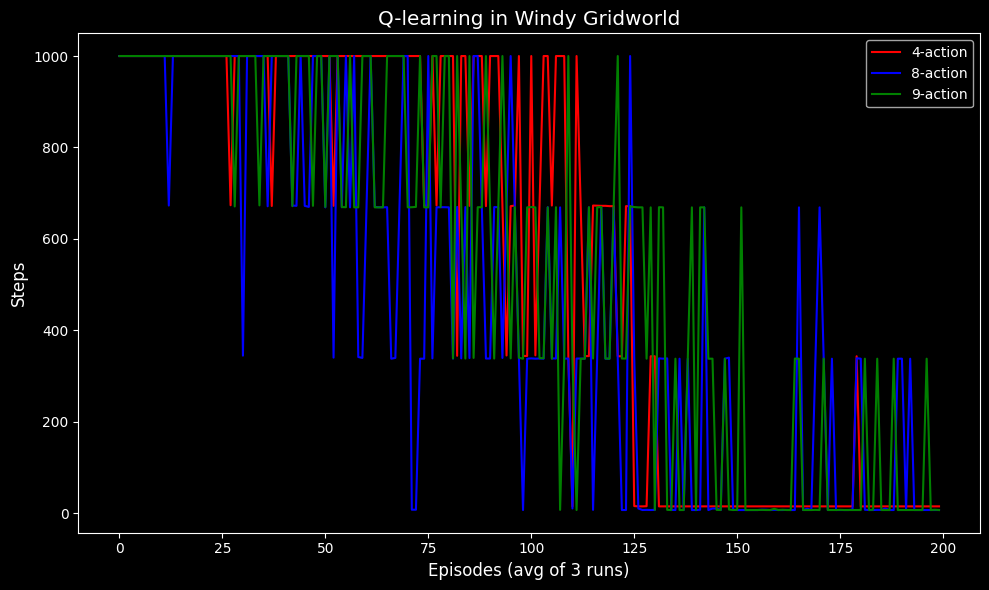

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

class WindyGridworld:
    """
    Windy Gridworld environment as in Sutton & Barto Example 6.5.
    State is (row, col).
    Actions can be 4-directional, 8-directional (king's moves), or 9-directional (king's moves + stay).
    """

    def __init__(self, rows=7, cols=10, 
                 start=(3, 0), goal=(3, 7),
                 wind_strength=None, 
                 king_moves=False,
                 stay_action=False):
        """
        rows, cols: dimensions of the grid
        start: (row, col) for the starting position
        goal: (row, col) for the goal
        wind_strength: list/array of length cols specifying how strong the wind 
                       is in each column (pushes the agent upward).
        king_moves: if True, 8 directions; otherwise 4 directions
        stay_action: if True and king_moves is True, adds a 9th 'stay' action
        """
        self.rows = rows
        self.cols = cols
        self.start = start
        self.goal = goal

        # Default wind strengths from Example 6.5 if not provided:
        # columns:  0 1 2 3 4 5 6 7 8 9
        # wind:     0 0 0 1 1 1 2 2 1 0
        if wind_strength is None:
            self.wind_strength = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]
        else:
            self.wind_strength = wind_strength

        # Define action set:
        if king_moves:
            # 8 directions (King's moves)
            # up, down, left, right, up-left, up-right, down-left, down-right
            self.actions = [(-1, 0), (1, 0), (0, -1), (0, 1),
                           (-1, -1), (-1, 1), (1, -1), (1, 1)]
            if stay_action:
                # Add 'stay' action
                self.actions.append((0, 0))
        else:
            # 4 directions: up, down, left, right
            self.actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

        self.n_actions = len(self.actions)
        self.action_names = []
        
        # Set action names for better tracking
        for i, action in enumerate(self.actions):
            if action == (-1, 0): self.action_names.append("up")
            elif action == (1, 0): self.action_names.append("down")
            elif action == (0, -1): self.action_names.append("left")
            elif action == (0, 1): self.action_names.append("right")
            elif action == (-1, -1): self.action_names.append("up-left")
            elif action == (-1, 1): self.action_names.append("up-right")
            elif action == (1, -1): self.action_names.append("down-left")
            elif action == (1, 1): self.action_names.append("down-right")
            elif action == (0, 0): self.action_names.append("stay")

        self.reset()

    def reset(self):
        """Reset agent to start state."""
        self.agent_pos = (self.start[0], self.start[1])
        return self.agent_pos

    def step(self, action):
        """
        action: integer in [0, self.n_actions)
        returns: (next_state, reward, done)
        """
        r, c = self.agent_pos

        # Apply wind (push upward by wind strength at column)
        r = r - self.wind_strength[c]

        # Apply chosen action
        dr, dc = self.actions[action]
        r += dr
        c += dc

        # Bound the agent within the grid
        r = max(0, min(self.rows - 1, r))
        c = max(0, min(self.cols - 1, c))

        # Update agent position
        self.agent_pos = (r, c)

        # Check goal
        if self.agent_pos == self.goal:
            return self.agent_pos, 0.0, True  # reward=0, done=True
        else:
            return self.agent_pos, -1.0, False  # step cost of -1


class QLearningAgent:
    """Q-learning agent for Windy Gridworld with support for different action sets."""

    def __init__(self, env, alpha=0.5, gamma=1.0, epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        # Q(s,a) stored in a dictionary keyed by (state, action)
        self.Q = defaultdict(float)

    def _epsilon_greedy_action(self, state):
        """Return an action using epsilon-greedy w.r.t. Q for the given state."""
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.env.n_actions)
        else:
            return self._greedy_action(state)
            
    def _greedy_action(self, state):
        """Return the greedy action according to Q values."""
        q_vals = [self.Q[(state, a)] for a in range(self.env.n_actions)]
        return np.argmax(q_vals)

    def learn_episode(self):
        """Run one episode of Q-learning in the environment and return number of steps."""
        state = self.env.reset()
        done = False
        steps = 0

        while not done:
            action = self._epsilon_greedy_action(state)
            next_state, reward, done = self.env.step(action)

            # Q-learning update:
            old_q = self.Q[(state, action)]
            # Off-policy: use max over next_state actions
            next_q_max = max(self.Q[(next_state, a)] for a in range(self.env.n_actions))
            td_target = reward + self.gamma * next_q_max
            self.Q[(state, action)] = old_q + self.alpha * (td_target - old_q)

            state = next_state
            steps += 1

        return steps
        
    def evaluate_policy(self, max_steps=1000):
        """Evaluate current policy (using greedy actions) and return steps to goal."""
        state = self.env.reset()
        done = False
        steps = 0
        
        while not done and steps < max_steps:
            action = self._greedy_action(state)
            next_state, reward, done = self.env.step(action)
            state = next_state
            steps += 1
            
        return steps if done else max_steps


def run_qlearning_experiment(is_king_moves=False, with_stay=False,
                          alpha=0.5, gamma=1.0, epsilon=0.1,
                          episodes=200, n_experiments=1):
    """
    Run Q-learning in Windy Gridworld for specified action set.
    Average results over n_experiments runs.
    
    Returns step counts for each episode, averaged over n_experiments.
    """
    all_results = []
    
    for _ in range(n_experiments):
        # Create environment and agent
        env = WindyGridworld(king_moves=is_king_moves, stay_action=with_stay)
        agent = QLearningAgent(env, alpha=alpha, gamma=gamma, epsilon=epsilon)
        
        # Track episode lengths
        episode_steps = []
        
        for _ in range(episodes):
            # Train for one episode
            _ = agent.learn_episode()
            
            # Evaluate current policy
            steps = agent.evaluate_policy()
            episode_steps.append(steps)
            
        all_results.append(episode_steps)
    
    # Average results over experiments
    avg_results = np.mean(all_results, axis=0)
    return avg_results


def main():
    # Parameters
    episodes = 200
    n_experiments = 3  # Set to higher value (e.g., 20) for smoother curves
    alpha = 0.5
    gamma = 1.0
    epsilon = 0.1
    
    # Run experiments for different action sets
    steps_4action = run_qlearning_experiment(
        is_king_moves=False, with_stay=False,
        alpha=alpha, gamma=gamma, epsilon=epsilon,
        episodes=episodes, n_experiments=n_experiments
    )
    
    steps_8action = run_qlearning_experiment(
        is_king_moves=True, with_stay=False,
        alpha=alpha, gamma=gamma, epsilon=epsilon,
        episodes=episodes, n_experiments=n_experiments
    )
    
    steps_9action = run_qlearning_experiment(
        is_king_moves=True, with_stay=True,
        alpha=alpha, gamma=gamma, epsilon=epsilon,
        episodes=episodes, n_experiments=n_experiments
    )
    
    # Plot 
    plt.style.use('dark_background')
    plt.figure(figsize=(10, 6))
    
    plt.plot(steps_4action, '-', c='red', label='4-action')
    plt.plot(steps_8action, '-', c='blue', label='8-action')
    plt.plot(steps_9action, '-', c='green', label='9-action')
    
    plt.title('Q-learning in Windy Gridworld', fontsize='x-large')
    plt.xlabel(f'Episodes (avg of {n_experiments} runs)', fontsize='large')
    plt.ylabel('Steps', fontsize='large')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

testing with 3 actions for Qlearning of Windy Gridworld
different initial positions, different wind logic (due to 1‐based vs. 0‐based indexing), different boundaries, and in this code below they even update Q during the test phase(Q-learning comparison from previous and this)

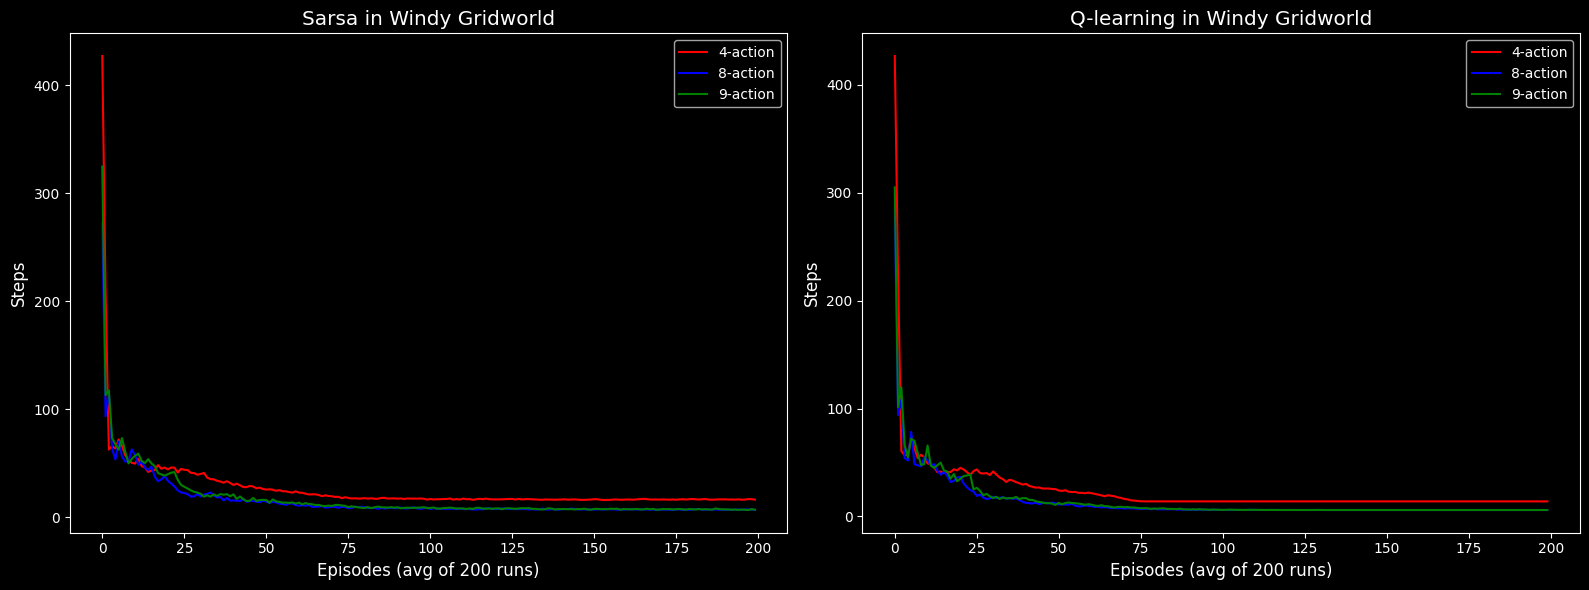

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

##############################################################################
#  1) FIRST VERSION (Sarsa-like approach)
##############################################################################

class WindyGridworldSarsa:
    def __init__(self, is_eight_action=False, ninth_action=False):
        self.xlimit = 10
        self.ylimit = 7
        self.is_eight_action = is_eight_action
        self.ninth_action = ninth_action
        # Hard-coded wind for each column: x in [1..10]
        self.wind_dict = {
            1: 0, 2: 0, 3: 0, 4: 1, 5: 1,
            6: 1, 7: 2, 8: 2, 9: 1, 10: 0
        }

    def step(self, pos, action):
        x, y = pos
        wind = self.wind_dict[x]
        if action == 'left':
            next_state = (max(1, x-1), min(y+wind, self.ylimit))
        elif action == 'right':
            next_state = (min(self.xlimit, x+1), min(y+wind, self.ylimit))
        elif action == 'up':
            next_state = (x, min(y+wind+1, self.ylimit))
        elif action == 'down':
            next_state = (x, max(0, min(y+wind-1, self.ylimit)))
        else:
            # Diagonals or 'stay' if allowed
            if self.is_eight_action:
                if action == 'left-up':
                    next_state = (max(1, x-1), min(y+wind+1, self.ylimit))
                elif action == 'left-down':
                    next_state = (max(1, x-1), max(0, min(y+wind-1, self.ylimit)))
                elif action == 'right-up':
                    next_state = (min(self.xlimit, x+1), min(y+wind+1, self.ylimit))
                elif action == 'right-down':
                    next_state = (min(self.xlimit, x+1), max(0, min(y+wind-1, self.ylimit)))
                else:
                    if self.ninth_action and action == 'stay':
                        next_state = (x, max(0, min(y+wind, self.ylimit)))
                    else:
                        raise ValueError("Invalid action for this environment.")
            else:
                raise ValueError("Invalid action for 4-action environment.")
        if next_state == (8, 4):
            return next_state, 0  # terminal
        else:
            return next_state, -1

class SarsaAgent:
    def __init__(self, alpha=0.5, gamma=1.0, eps=0.1,
                 is_eight_action=False, ninth_action=False):
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        self.Q = defaultdict(int)
        # Action space
        if not is_eight_action:
            self.action_space = ['left', 'right', 'up', 'down']
        else:
            if ninth_action:
                self.action_space = [
                    'left', 'right', 'up', 'down',
                    'left-up', 'left-down', 'right-up', 'right-down', 'stay'
                ]
            else:
                self.action_space = [
                    'left', 'right', 'up', 'down',
                    'left-up', 'left-down', 'right-up', 'right-down'
                ]

    def greedy(self, state):
        best_a = self.action_space[0]
        best_q = self.Q[(state, best_a)]
        for a in self.action_space:
            if self.Q[(state, a)] > best_q:
                best_q = self.Q[(state, a)]
                best_a = a
        return best_a

    def e_greedy(self, state):
        if np.random.rand() < self.eps:
            return np.random.choice(self.action_space)
        else:
            return self.greedy(state)

    def update(self, R, state, action, next_state, next_action):
        """Sarsa update: Q(s,a) <- Q(s,a) + alpha*[r + gamma*Q(s',a') - Q(s,a)]."""
        if R == 0:
            # terminal next_Q = 0
            next_q = 0
        else:
            next_q = self.Q[(next_state, next_action)]
        self.Q[(state, action)] += self.alpha * (R + self.gamma*next_q - self.Q[(state, action)])

def run_sarsa_game(is_eight_action=False, ninth_action=False,
                   alpha=0.5, gamma=1.0, eps=0.1,
                   episodes=200, max_steps=5000):
    """
    Runs 'episodes' episodes of the Sarsa approach in WindyGridworldSarsa.
    After each training episode, do a test (greedy) run to measure steps to goal.
    Return a list 'hist' of the test-run step counts (episode by episode).
    """
    env = WindyGridworldSarsa(is_eight_action, ninth_action)
    agent = SarsaAgent(alpha=alpha, gamma=gamma, eps=eps,
                       is_eight_action=is_eight_action, ninth_action=ninth_action)
    hist = []
    start_state = (1, 4)

    for _ in range(episodes):
        # ---- Training with Sarsa ----
        state = start_state
        action = agent.e_greedy(state)
        for _ in range(max_steps):
            next_state, R = env.step(state, action)
            next_action = agent.e_greedy(next_state)
            agent.update(R, state, action, next_state, next_action)
            state, action = next_state, next_action
            if R == 0:  # terminal
                break

        # ---- Test run (greedy) to measure steps ----
        steps = 0
        state = start_state
        action = agent.greedy(state)
        for step in range(max_steps):
            next_state, R = env.step(state, action)
            next_action = agent.greedy(next_state)
            # Optionally update or not during test; won't matter for terminal detection
            agent.update(R, state, action, next_state, next_action)
            state, action = next_state, next_action
            if R == 0:
                steps = step
                break
        hist.append(steps)

    return hist

def run_sarsa_experiments(n_experiments=200, episodes=200):
    """Run the Sarsa-based approach for 4-action, 8-action, and 9-action, averaged over n_experiments."""
    all_4, all_8, all_9 = [], [], []
    for _ in range(n_experiments):
        h4 = run_sarsa_game(is_eight_action=False, ninth_action=False, episodes=episodes)
        h8 = run_sarsa_game(is_eight_action=True, ninth_action=False, episodes=episodes)
        h9 = run_sarsa_game(is_eight_action=True, ninth_action=True, episodes=episodes)
        all_4.append(h4)
        all_8.append(h8)
        all_9.append(h9)

    hist_4 = np.mean(all_4, axis=0)
    hist_8 = np.mean(all_8, axis=0)
    hist_9 = np.mean(all_9, axis=0)
    return hist_4, hist_8, hist_9


##############################################################################
#  2) SECOND VERSION (Q-learning approach)
##############################################################################

class WindyGridworldQ:
    """
    Same layout but used for the Q-learning version to keep code separate.
    (Could be the same environment in practice.)
    """
    def __init__(self, is_eight_action=False, ninth_action=False):
        self.xlimit = 10
        self.ylimit = 7
        self.is_eight_action = is_eight_action
        self.ninth_action = ninth_action
        self.wind_dict = {
            1: 0, 2: 0, 3: 0, 4: 1, 5: 1,
            6: 1, 7: 2, 8: 2, 9: 1, 10: 0
        }

    def step(self, pos, action):
        x, y = pos
        wind = self.wind_dict[x]
        if action == 'left':
            next_state = (max(1, x-1), min(y+wind, self.ylimit))
        elif action == 'right':
            next_state = (min(self.xlimit, x+1), min(y+wind, self.ylimit))
        elif action == 'up':
            next_state = (x, min(y+wind+1, self.ylimit))
        elif action == 'down':
            next_state = (x, max(0, min(y+wind-1, self.ylimit)))
        else:
            # Diagonal or stay
            if self.is_eight_action:
                if action == 'left-up':
                    next_state = (max(1, x-1), min(y+wind+1, self.ylimit))
                elif action == 'left-down':
                    next_state = (max(1, x-1), max(0, min(y+wind-1, self.ylimit)))
                elif action == 'right-up':
                    next_state = (min(self.xlimit, x+1), min(y+wind+1, self.ylimit))
                elif action == 'right-down':
                    next_state = (min(self.xlimit, x+1), max(0, min(y+wind-1, self.ylimit)))
                else:
                    if self.ninth_action and action == 'stay':
                        next_state = (x, max(0, min(y+wind, self.ylimit)))
                    else:
                        raise ValueError("Invalid action.")
            else:
                raise ValueError("Invalid action for 4-action environment.")
        if next_state == (8, 4):
            return next_state, 0
        else:
            return next_state, -1

class QLearningAgent:
    def __init__(self, alpha=0.5, gamma=1.0, eps=0.1,
                 is_eight_action=False, ninth_action=False):
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        self.Q = defaultdict(float)

        if not is_eight_action:
            self.action_space = ['left', 'right', 'up', 'down']
        else:
            if ninth_action:
                self.action_space = [
                    'left', 'right', 'up', 'down',
                    'left-up', 'left-down', 'right-up', 'right-down',
                    'stay'
                ]
            else:
                self.action_space = [
                    'left', 'right', 'up', 'down',
                    'left-up', 'left-down', 'right-up', 'right-down'
                ]

    def _greedy_action(self, state):
        best_a = self.action_space[0]
        best_q = self.Q[(state, best_a)]
        for a in self.action_space:
            if self.Q[(state, a)] > best_q:
                best_q = self.Q[(state, a)]
                best_a = a
        return best_a

    def _epsilon_greedy_action(self, state):
        if np.random.rand() < self.eps:
            return np.random.choice(self.action_space)
        else:
            return self._greedy_action(state)

    def update_qlearning(self, state, action, reward, next_state):
        old_q = self.Q[(state, action)]
        max_next_q = max(self.Q[(next_state, a)] for a in self.action_space)
        td_target = reward + self.gamma * max_next_q
        self.Q[(state, action)] = old_q + self.alpha * (td_target - old_q)

def run_qlearning_game(is_eight_action=False, ninth_action=False,
                      alpha=0.5, gamma=1.0, eps=0.1,
                      episodes=200, max_steps=5000):
    """
    Q-learning in WindyGridworldQ for 'episodes' episodes.
    After each training episode, do a greedy run to measure steps to goal.
    Return a list of step counts (hist).
    """
    env = WindyGridworldQ(is_eight_action, ninth_action)
    agent = QLearningAgent(alpha=alpha, gamma=gamma, eps=eps,
                           is_eight_action=is_eight_action, ninth_action=ninth_action)
    hist = []
    start_state = (1, 4)

    for _ in range(episodes):
        # ---- Training Phase (Q-learning) ----
        state = start_state
        for _ in range(max_steps):
            action = agent._epsilon_greedy_action(state)
            next_state, reward = env.step(state, action)
            agent.update_qlearning(state, action, reward, next_state)
            state = next_state
            if reward == 0:
                break

        # ---- Test Phase (greedy) to measure steps ----
        steps = 0
        state = start_state
        for step in range(max_steps):
            action = agent._greedy_action(state)
            next_state, reward = env.step(state, action)
            # (optional) agent.update_qlearning(...) in test
            agent.update_qlearning(state, action, reward, next_state)
            state = next_state
            if reward == 0:
                steps = step
                break
        hist.append(steps)

    return hist

def run_qlearning_experiments(n_experiments=200, episodes=200):
    """Run Q-learning for 4, 8, and 9 actions, averaged over n_experiments."""
    all_4, all_8, all_9 = [], [], []
    for _ in range(n_experiments):
        h4 = run_qlearning_game(is_eight_action=False, ninth_action=False, episodes=episodes)
        h8 = run_qlearning_game(is_eight_action=True, ninth_action=False, episodes=episodes)
        h9 = run_qlearning_game(is_eight_action=True, ninth_action=True, episodes=episodes)
        all_4.append(h4)
        all_8.append(h8)
        all_9.append(h9)

    hist_4 = np.mean(all_4, axis=0)
    hist_8 = np.mean(all_8, axis=0)
    hist_9 = np.mean(all_9, axis=0)
    return hist_4, hist_8, hist_9

##############################################################################
#  3) RUN BOTH & PLOT SIDE BY SIDE
##############################################################################

def main():
    # Parameters
    EPISODES = 200
    N_EXPERIMENTS = 200
    
    # 1) Run Sarsa-based approach
    sarsa_4, sarsa_8, sarsa_9 = run_sarsa_experiments(n_experiments=N_EXPERIMENTS, episodes=EPISODES)

    # 2) Run Q-learning approach
    q_4, q_8, q_9 = run_qlearning_experiments(n_experiments=N_EXPERIMENTS, episodes=EPISODES)

    # 3) Plot side by side
    plt.style.use('dark_background')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Left subplot: Sarsa results
    ax1.plot(sarsa_4, '-', c='red', label='4-action')
    ax1.plot(sarsa_8, '-', c='blue', label='8-action')
    ax1.plot(sarsa_9, '-', c='green', label='9-action')
    ax1.set_title('Sarsa in Windy Gridworld', fontsize='x-large')
    ax1.set_xlabel(f'Episodes (avg of {N_EXPERIMENTS} runs)', fontsize='large')
    ax1.set_ylabel('Steps', fontsize='large')
    ax1.legend()

    # Right subplot: Q-learning results
    ax2.plot(q_4, '-', c='red', label='4-action')
    ax2.plot(q_8, '-', c='blue', label='8-action')
    ax2.plot(q_9, '-', c='green', label='9-action')
    ax2.set_title('Q-learning in Windy Gridworld', fontsize='x-large')
    ax2.set_xlabel(f'Episodes (avg of {N_EXPERIMENTS} runs)', fontsize='large')
    ax2.set_ylabel('Steps', fontsize='large')
    ax2.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Sarsa Windy Gridworld with King’s moves

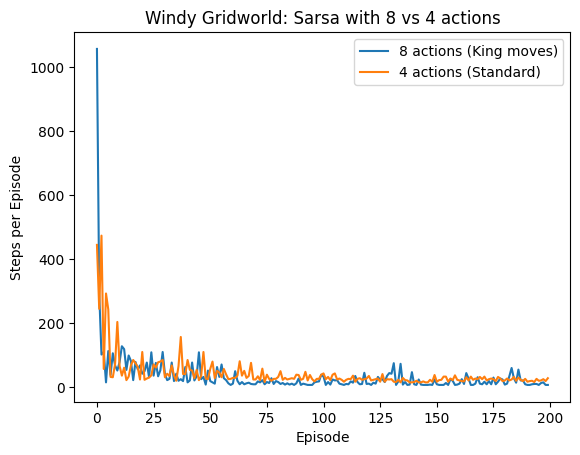

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random

class WindyGridworld:
    """
    Windy Gridworld environment as in Sutton & Barto Example 6.5,
    but modified for 8 possible moves (Exercise 6.10).
    
    State is (row, col).
    Actions are integer indices into the set of 8 moves.
    """

    def __init__(self, rows=7, cols=10, 
                 start=(3, 0), goal=(3, 7),
                 wind_strength=None,
                 king_moves=True):
        """
        rows, cols: dimensions of the grid
        start: (row, col) for the starting position
        goal: (row, col) for the goal
        wind_strength: list/array of length cols specifying how strong the wind 
                       is in each column (pushes the agent upward).
        king_moves: if True, allow 8-direction moves; if False, only 4 directions.
        """
        self.rows = rows
        self.cols = cols
        self.start = start
        self.goal = goal

        # Default wind strengths from Example 6.5 if not provided:
        # columns:  0 1 2 3 4 5 6 7 8 9
        # wind:     0 0 0 1 1 1 2 2 1 0
        if wind_strength is None:
            self.wind_strength = [0,0,0,1,1,1,2,2,1,0]
        else:
            self.wind_strength = wind_strength

        # Define action set:
        # Standard 4 moves: up, right, down, left
        # 8 moves (King's moves): up, down, left, right, plus diagonals
        if king_moves:
            # up, down, left, right, diag up-left, diag up-right, diag down-left, diag down-right
            self.actions = [(-1,0), (1,0), (0,-1), (0,1),
                            (-1,-1), (-1,1), (1,-1), (1,1)]
        else:
            self.actions = [(-1,0), (1,0), (0,-1), (0,1)]

        self.n_actions = len(self.actions)

        self.reset()

    def reset(self):
        """Reset agent to start state."""
        self.agent_pos = (self.start[0], self.start[1])
        return self.agent_pos

    def step(self, action):
        """
        action: integer in [0, self.n_actions)
        returns: (next_state, reward, done)
        """
        # Current position
        r, c = self.agent_pos

        # Wind pushes the agent up by wind_strength at the current column
        wind = self.wind_strength[c]

        # Apply wind
        r = r - wind

        # Apply the chosen action
        dr, dc = self.actions[action]
        r += dr
        c += dc

        # Bound the agent within the grid
        r = max(0, min(self.rows - 1, r))
        c = max(0, min(self.cols - 1, c))

        # Update the agent's position
        self.agent_pos = (r, c)

        # Check for goal
        if self.agent_pos == self.goal:
            return self.agent_pos, 0.0, True  # reward=0, done=True (or use +1 for preference)
        else:
            return self.agent_pos, -1.0, False  # typically a step cost of -1

class SarsaAgent:
    """
    An agent that learns a policy in WindyGridworld via Sarsa.
    """
    def __init__(self, env, alpha=0.5, gamma=1.0, epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

        # Q(s,a) can be stored in a dictionary keyed by (row, col, action)
        # or by a nested defaultdict
        self.Q = defaultdict(float)

    def _epsilon_greedy_action(self, state):
        """
        Return an action using epsilon-greedy w.r.t. Q for the given state.
        """
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.env.n_actions)
        else:
            # Choose argmax action
            q_vals = [self.Q[(state, a)] for a in range(self.env.n_actions)]
            return np.argmax(q_vals)

    def learn_episode(self):
        """
        Run one episode of Sarsa in the environment, 
        update Q as we go, and return the episode length (# of steps).
        """
        state = self.env.reset()
        action = self._epsilon_greedy_action(state)

        steps = 0
        done = False
        while not done:
            next_state, reward, done = self.env.step(action)
            next_action = self._epsilon_greedy_action(next_state)

            # Update Q
            old_q = self.Q[(state, action)]
            td_target = reward + self.gamma * self.Q[(next_state, next_action)]
            self.Q[(state, action)] += self.alpha * (td_target - old_q)

            state = next_state
            action = next_action
            steps += 1

        return steps

def run_windy_gridworld_sarsa(
        episodes=200, 
        alpha=0.5, gamma=1.0, epsilon=0.1, 
        king_moves=True):
    """
    Create the windy gridworld environment (with or without king's moves),
    run Sarsa for a number of episodes, and track the number of steps per episode.
    """
    env = WindyGridworld(king_moves=king_moves)
    agent = SarsaAgent(env, alpha=alpha, gamma=gamma, epsilon=epsilon)

    steps_per_episode = []
    for ep in range(episodes):
        steps = agent.learn_episode()
        steps_per_episode.append(steps)

    return steps_per_episode

def main():
    # Compare 8-action (king_moves=True) vs 4-action (king_moves=False)
    episodes = 200
    alpha = 0.5
    gamma = 1.0
    epsilon = 0.1

    # 8-direction version (Exercise 6.10)
    steps_kings = run_windy_gridworld_sarsa(
        episodes=episodes, alpha=alpha, gamma=gamma, 
        epsilon=epsilon, king_moves=True
    )

    # 4-direction version (baseline)
    steps_standard = run_windy_gridworld_sarsa(
        episodes=episodes, alpha=alpha, gamma=gamma, 
        epsilon=epsilon, king_moves=False
    )

    # Plot comparison
    plt.plot(steps_kings, label='8 actions (King moves)')
    plt.plot(steps_standard, label='4 actions (Standard)')
    plt.xlabel('Episode')
    plt.ylabel('Steps per Episode')
    plt.title('Windy Gridworld: Sarsa with 8 vs 4 actions')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()


3 actions comparison

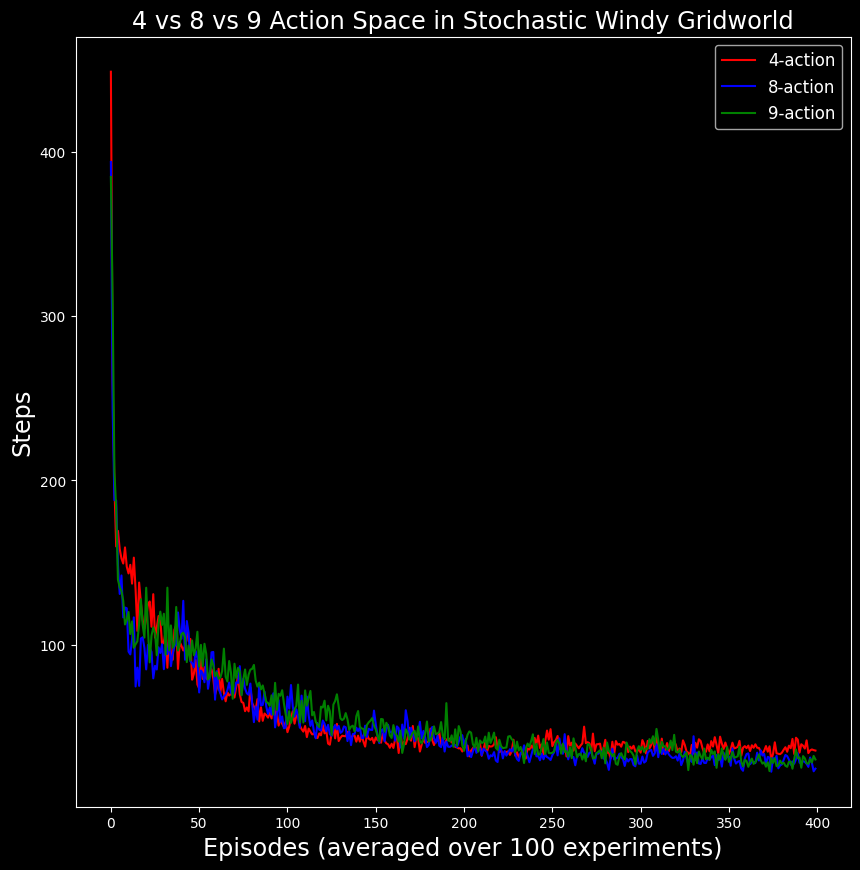

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# -------------------- Environment Definition -------------------- #
class WindyGridworld:
    def __init__(self, is_eight_action=False, ninth_action=False):
        """
        Gridworld with:
         - x positions from 1 to 10 (columns)
         - y positions from 0 to 7 (rows; note: rows are labeled 0..7 so that min(y) is 0 and max(y)=7)
           (the provided code uses 1-index for x and 0-index for y for convenience)
         - Start state: (1, 4)
         - Terminal state: (8, 4)
        Parameters:
         - is_eight_action: if True, allow diagonal moves (8 actions total)
         - ninth_action: if True (and is_eight_action is True), add an extra "stay" action (9 actions total)
        """
        self.xlimit = 10
        self.ylimit = 7
        self.is_eight_action = is_eight_action
        self.ninth_action = ninth_action
        # Define wind strength for each column (x coordinate)
        self.wind_dict = {1: 0, 2: 0, 3: 0, 4: 1, 5: 1,
                          6: 1, 7: 2, 8: 2, 9: 1, 10: 0}

    def step(self, pos, action):
        """
        Given a state (pos) and an action (a string), compute the next state.
        A stochastic wind factor (random integer in [-1, 1]) is added to the y-coordinate.
        Returns (next_state, reward). Reward is 0 if terminal; otherwise -1.
        """
        x, y = pos
        wind = self.wind_dict[x]
        # Compute new position based on action
        if action == 'left':
            next_state = (max(1, x - 1), min(y + wind, self.ylimit))
        elif action == 'right':
            next_state = (min(self.xlimit, x + 1), min(y + wind, self.ylimit))
        elif action == 'up':
            next_state = (x, min(y + wind + 1, self.ylimit))
        elif action == 'down':
            next_state = (x, max(0, min(y + wind - 1, self.ylimit)))
        else:
            # Diagonal moves (only allowed if is_eight_action is True)
            if self.is_eight_action:
                if action == 'left-up':
                    next_state = (max(1, x - 1), min(y + wind + 1, self.ylimit))
                elif action == 'left-down':
                    next_state = (max(1, x - 1), max(0, min(y + wind - 1, self.ylimit)))
                elif action == 'right-up':
                    next_state = (min(self.xlimit, x + 1), min(y + wind + 1, self.ylimit))
                elif action == 'right-down':
                    next_state = (min(self.xlimit, x + 1), max(0, min(y + wind - 1, self.ylimit)))
                else:
                    if self.ninth_action:
                        if action == 'stay':
                            next_state = (x, max(0, min(y + wind, self.ylimit)))
                        else:
                            raise ValueError("Invalid action")
                    else:
                        raise ValueError("Invalid action")
            else:
                raise ValueError("Invalid action")

        # ------------------- Stochastic Wind Factor (Ex 6.10) ------------------- #
        random_factor = np.random.randint(-1, 2)  # random integer from -1 to 1
        next_state = (next_state[0], max(0, min(next_state[1] + random_factor, self.ylimit)))
        # -------------------------------------------------------------------------- #

        # Check if terminal state is reached
        if next_state == (8, 4):
            return next_state, 0
        else:
            return next_state, -1

# ------------------------ Agent Definition ------------------------ #
class Agent:
    def __init__(self, alpha=0.5, gamma=1, eps=0.1, is_eight_action=False, ninth_action=False):
        """
        Agent using Sarsa to learn in the Windy Gridworld.
        """
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        self.Q = defaultdict(int)
        if not is_eight_action:
            self.action_space = ['left', 'right', 'up', 'down']
        else:
            if ninth_action:
                self.action_space = ['left', 'right', 'up', 'down',
                                     'left-up', 'left-down', 'right-up', 'right-down', 'stay']
            else:
                self.action_space = ['left', 'right', 'up', 'down',
                                     'left-up', 'left-down', 'right-up', 'right-down']

    def greedy(self, state):
        """Return the best action (highest Q-value) at the given state."""
        best_action = self.action_space[0]
        best_Q = self.Q[(state, best_action)]
        for a in self.action_space:
            if self.Q[(state, a)] > best_Q:
                best_action = a
                best_Q = self.Q[(state, a)]
        return best_action

    def e_greedy(self, state):
        """Return an epsilon-greedy action at the given state."""
        if np.random.random() > self.eps:
            return self.greedy(state)
        else:
            return np.random.choice(self.action_space)

    def update(self, R, state, action, next_state, next_action):
        """
        Sarsa update rule.
        If the reward R is 0 (terminal state), then we use 0 for the next Q value.
        """
        if R == 0:
            next_Q = 0
        else:
            next_Q = self.Q[(next_state, next_action)]
        self.Q[(state, action)] += self.alpha * (R + self.gamma * next_Q - self.Q[(state, action)])

# ------------------------- Episode Runner ------------------------- #
def run_episode(is_eight_action=False, ninth_action=False, EPISODE=400):
    """
    Run learning for a number of episodes in the Windy Gridworld.
    For each episode, first run a learning episode (with exploration) then a test episode (greedy)
    to record the number of steps taken.
    """
    env = WindyGridworld(is_eight_action=is_eight_action, ninth_action=ninth_action)
    agent = Agent(is_eight_action=is_eight_action, ninth_action=ninth_action)
    episode_steps = []  # steps taken (in the test run) per episode

    for episode in range(EPISODE):
        # --- Learning Phase (with e-greedy exploration) --- #
        state = (1, 4)  # start state
        action = agent.e_greedy(state)
        for step in range(5000):
            next_state, R = env.step(state, action)
            next_action = agent.e_greedy(next_state)
            agent.update(R, state, action, next_state, next_action)
            state = next_state
            action = next_action
            if R == 0:  # reached terminal state
                break

        # --- Testing Phase (greedy policy only) --- #
        state = (1, 4)
        action = agent.greedy(state)
        for step in range(5000):
            next_state, R = env.step(state, action)
            next_action = agent.greedy(next_state)
            agent.update(R, state, action, next_state, next_action)
            state = next_state
            action = next_action
            if R == 0:
                episode_steps.append(step)
                break
    return episode_steps

# ------------------------- Experiment Runner ------------------------- #
def run_experiments(n_experiments=100, EPISODE=400):
    """
    Run multiple experiments and average the steps per episode over experiments.
    Returns three arrays: averaged steps for 4-action, 8-action, and 9-action agents.
    """
    results_4 = []
    results_8 = []
    results_9 = []
    for exp in range(n_experiments):
        results_4.append(run_episode(is_eight_action=False, ninth_action=False, EPISODE=EPISODE))
        results_8.append(run_episode(is_eight_action=True, ninth_action=False, EPISODE=EPISODE))
        results_9.append(run_episode(is_eight_action=True, ninth_action=True, EPISODE=EPISODE))
    # Average the episode lengths over experiments (axis=0 averages episode-by-episode)
    results_4_avg = np.mean(results_4, axis=0)
    results_8_avg = np.mean(results_8, axis=0)
    results_9_avg = np.mean(results_9, axis=0)
    return results_4_avg, results_8_avg, results_9_avg

# ----------------------------- Main ----------------------------- #
def main():
    EPISODE = 400
    n_experiments = 100
    hist_4, hist_8, hist_9 = run_experiments(n_experiments=n_experiments, EPISODE=EPISODE)

    # Plotting using dark background style with distinct colors and a legend
    plt.style.use('dark_background')
    plt.figure(figsize=(10, 10))
    plt.title('4 vs 8 vs 9 Action Space in Stochastic Windy Gridworld', fontsize='xx-large')
    plt.xlabel(f'Episodes (averaged over {n_experiments} experiments)', fontsize='xx-large')
    plt.ylabel('Steps', fontsize='xx-large')
    plt.plot(hist_4, '-', c='red', label='4-action')
    plt.plot(hist_8, '-', c='blue', label='8-action')
    plt.plot(hist_9, '-', c='green', label='9-action')
    plt.legend(loc='best', prop={'size': 12})
    plt.show()

if __name__ == "__main__":
    main()
